In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.svm import LinearSVC

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

In [2]:
rootpath = "../data"
sub_id = "dy016"
samp_freq = 30_000

In [3]:
# load our localization data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=False, samp_freq=samp_freq)

In [4]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [5]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = False)

choices left: 0.769, right: 0.231
stimuli left: 0.507, right: 0.493
reward wrong: 0.231, correct: 0.769


In [6]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] 

model selection

https://scikit-learn.org/0.16/auto_examples/mixture/plot_gmm_classifier.html

In [10]:
sample_spikes = [trial[np.random.choice(len(trial), 500), 1:] for trial in trials]
sample_spikes = np.vstack(sample_spikes)
print(sample_spikes.shape)

(143000, 3)


In [13]:
lowest_aic = np.infty
lowest_bic = np.infty
aic = []; bic = []
k_range = range(350, 460, 10)

for k in k_range:
    print(f'--- fitting MoG with {k} gaussians ---')
    gmm = GaussianMixture(
        init_params='kmeans',
        n_components=k, 
        covariance_type='full',
        random_state=seed, warm_start=True, 
        verbose=1, verbose_interval=10
    )
    gmm.fit(sample_spikes)
    aic.append(gmm.aic(sample_spikes))
    bic.append(gmm.bic(sample_spikes))
    if aic[-1] < lowest_aic:
        lowest_aic = aic[-1]
        best_aic_gmm = gmm
    if bic[-1] < lowest_bic:
        lowest_bic = bic[-1]
        best_bic_gmm = gmm
    print(f'current aic: {round(aic[-1],2)} bic: {round(bic[-1],2)}')
    print(f'best aic MoG has {len(best_aic_gmm.weights_)} gaussians.')
    print(f'best bic MoG has {len(best_bic_gmm.weights_)} gaussians.')

In [8]:
initial_gmm = GaussianMixture(
        init_params='kmeans',
        n_components=380, 
        covariance_type='full',
        random_state=seed, warm_start=True, 
        verbose=1, verbose_interval=1
    )
initial_gmm.fit(structured_unsorted)

Initialization 0
  Iteration 1
  Iteration 2
  Iteration 3
  Iteration 4
  Iteration 5
  Iteration 6
  Iteration 7
  Iteration 8
  Iteration 9
  Iteration 10
  Iteration 11
  Iteration 12
  Iteration 13
  Iteration 14
  Iteration 15
  Iteration 16
  Iteration 17
  Iteration 18
  Iteration 19
  Iteration 20
  Iteration 21
  Iteration 22
Initialization converged: True


GaussianMixture(n_components=380, random_state=666, verbose=1,
                verbose_interval=1, warm_start=True)

In [9]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

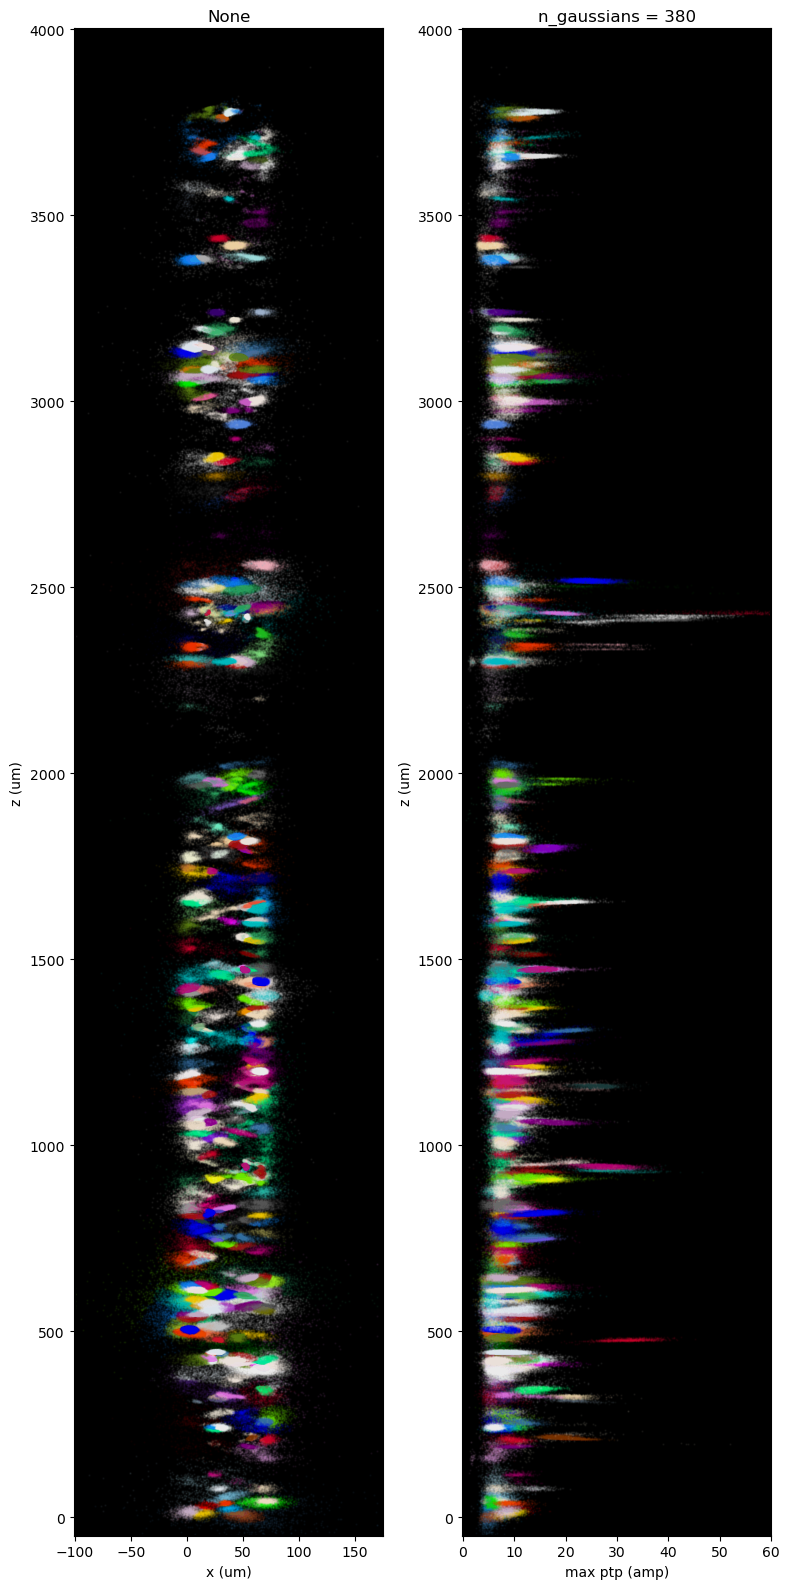

In [10]:
viz_tools.plot_gaussian_mixtures(sub_id, structured_unsorted, initial_labels, initial_labels, display_all_spikes=True, n_spikes_display=1_000)

In [11]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, initial_labels, initial_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (286, 380, 30)
clusterless neural projections shape: (286, 380, 15)
clusterless neural reconstructions shape: (286, 380, 30)


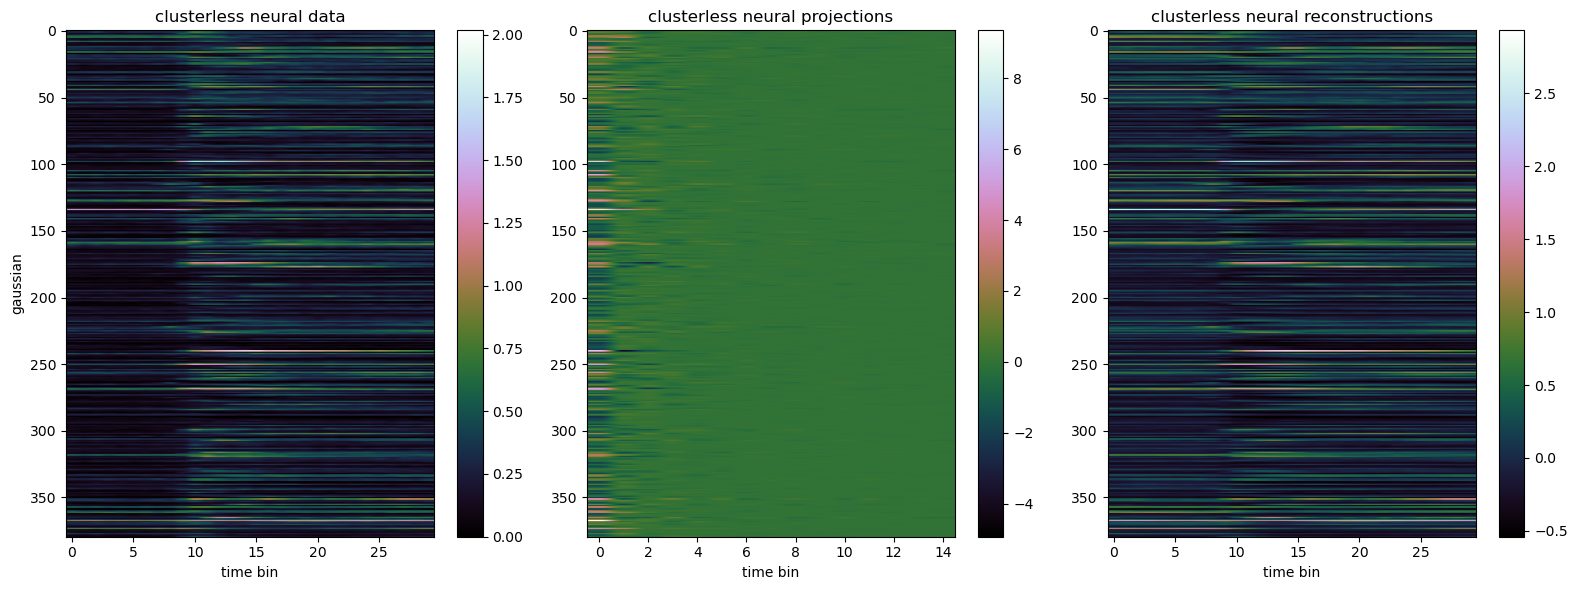

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [13]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.931 auc: 0.971
choice fold 2 test accuracy: 0.930 auc: 0.946
choice fold 3 test accuracy: 0.930 auc: 0.970
choice fold 4 test accuracy: 0.895 auc: 0.949
choice fold 5 test accuracy: 0.877 auc: 0.932
choice mean of 5-fold cv accuracy: 0.913 auc: 0.954
choice sd of 5-fold cv accuracy: 0.022 auc: 0.015
stimulus fold 1 test accuracy: 0.379 auc: 0.799
stimulus fold 2 test accuracy: 0.281 auc: 0.756
stimulus fold 3 test accuracy: 0.298 auc: 0.718
stimulus fold 4 test accuracy: 0.368 auc: 0.802
stimulus fold 5 test accuracy: 0.368 auc: 0.741
stimulus mean of 5-fold cv accuracy: 0.339 auc: 0.763
stimulus sd of 5-fold cv accuracy: 0.041 auc: 0.033


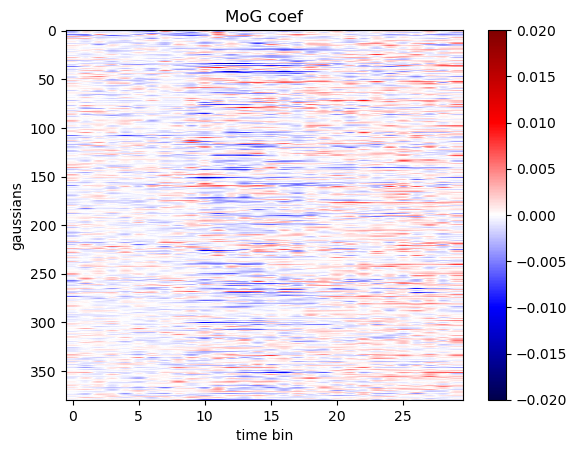

In [14]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()